In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from scipy.optimize import curve_fit
import os, sys
import warnings

def station_hit_probability(x : np.ndarray, prob_50 : float, scale : float) -> np.ndarray :
    return np.clip(1 - 1 / (1 + np.exp(-scale * (x - prob_50))), 0, 1)

def station_hit_probability_error(x : np.ndarray, pcov : np.ndarray, prob_50 : float, scale : float) -> np.ndarray :

    errors = np.zeros_like(x)

    d_prob_50 = lambda u : scale * np.exp(scale * (u + prob_50)) / (np.exp(prob_50 * scale) + np.exp(scale * u))**2
    d_scale = lambda u : (prob_50 - u) * np.exp(scale * (prob_50 + u)) / (np.exp(prob_50 * scale) + np.exp(scale * u))**2

    for i, X in enumerate(x):
        gradient = np.array([d_prob_50(X), d_scale(X)])
        errors[i] += np.sqrt(gradient.T @ pcov @ gradient)

    return errors

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


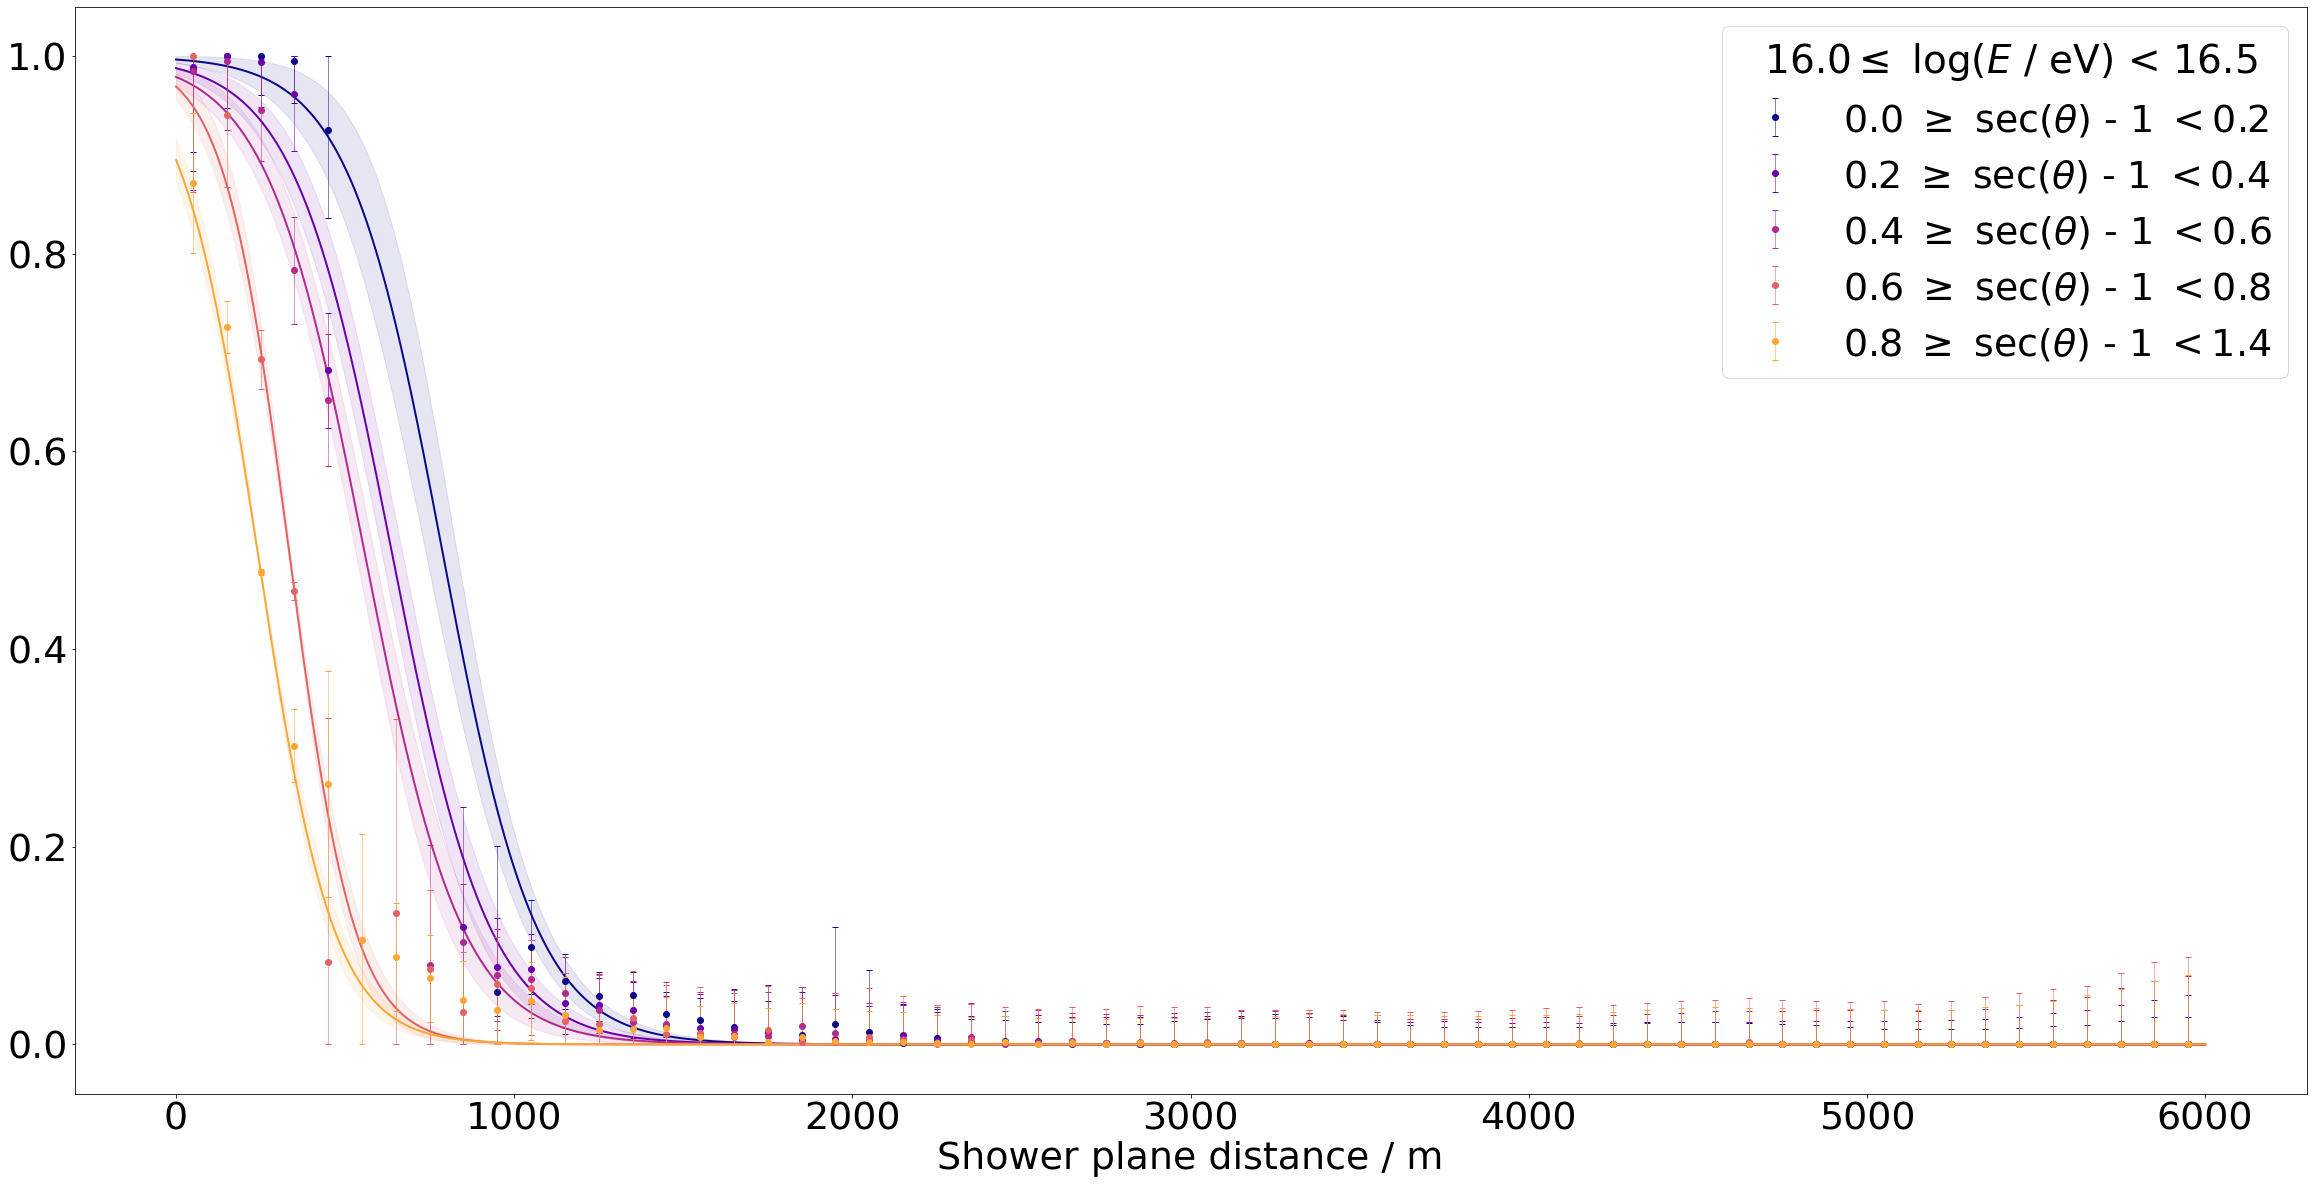

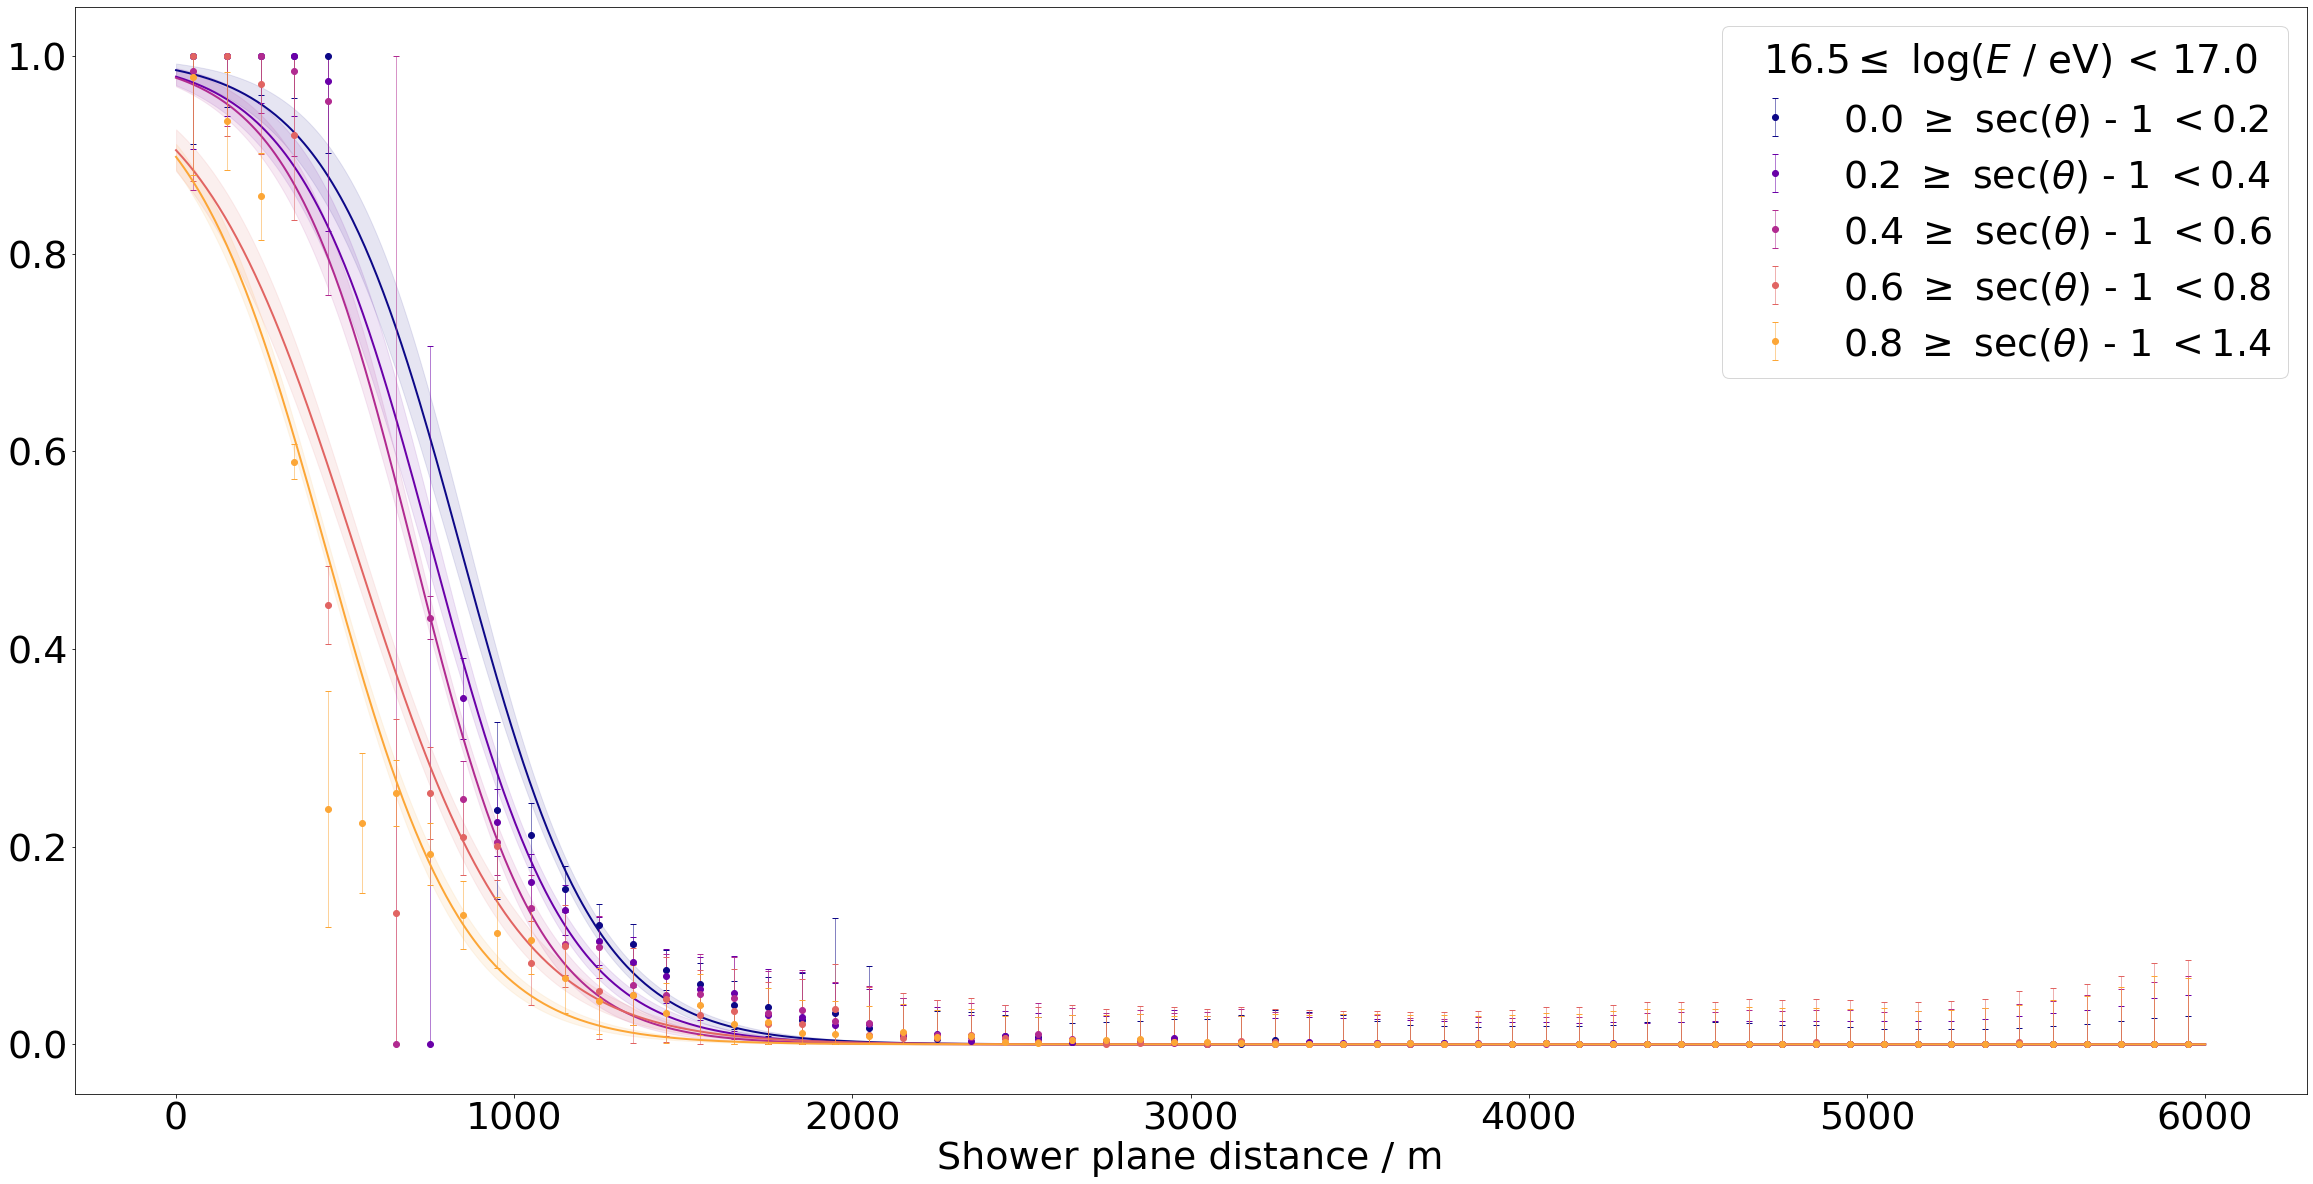

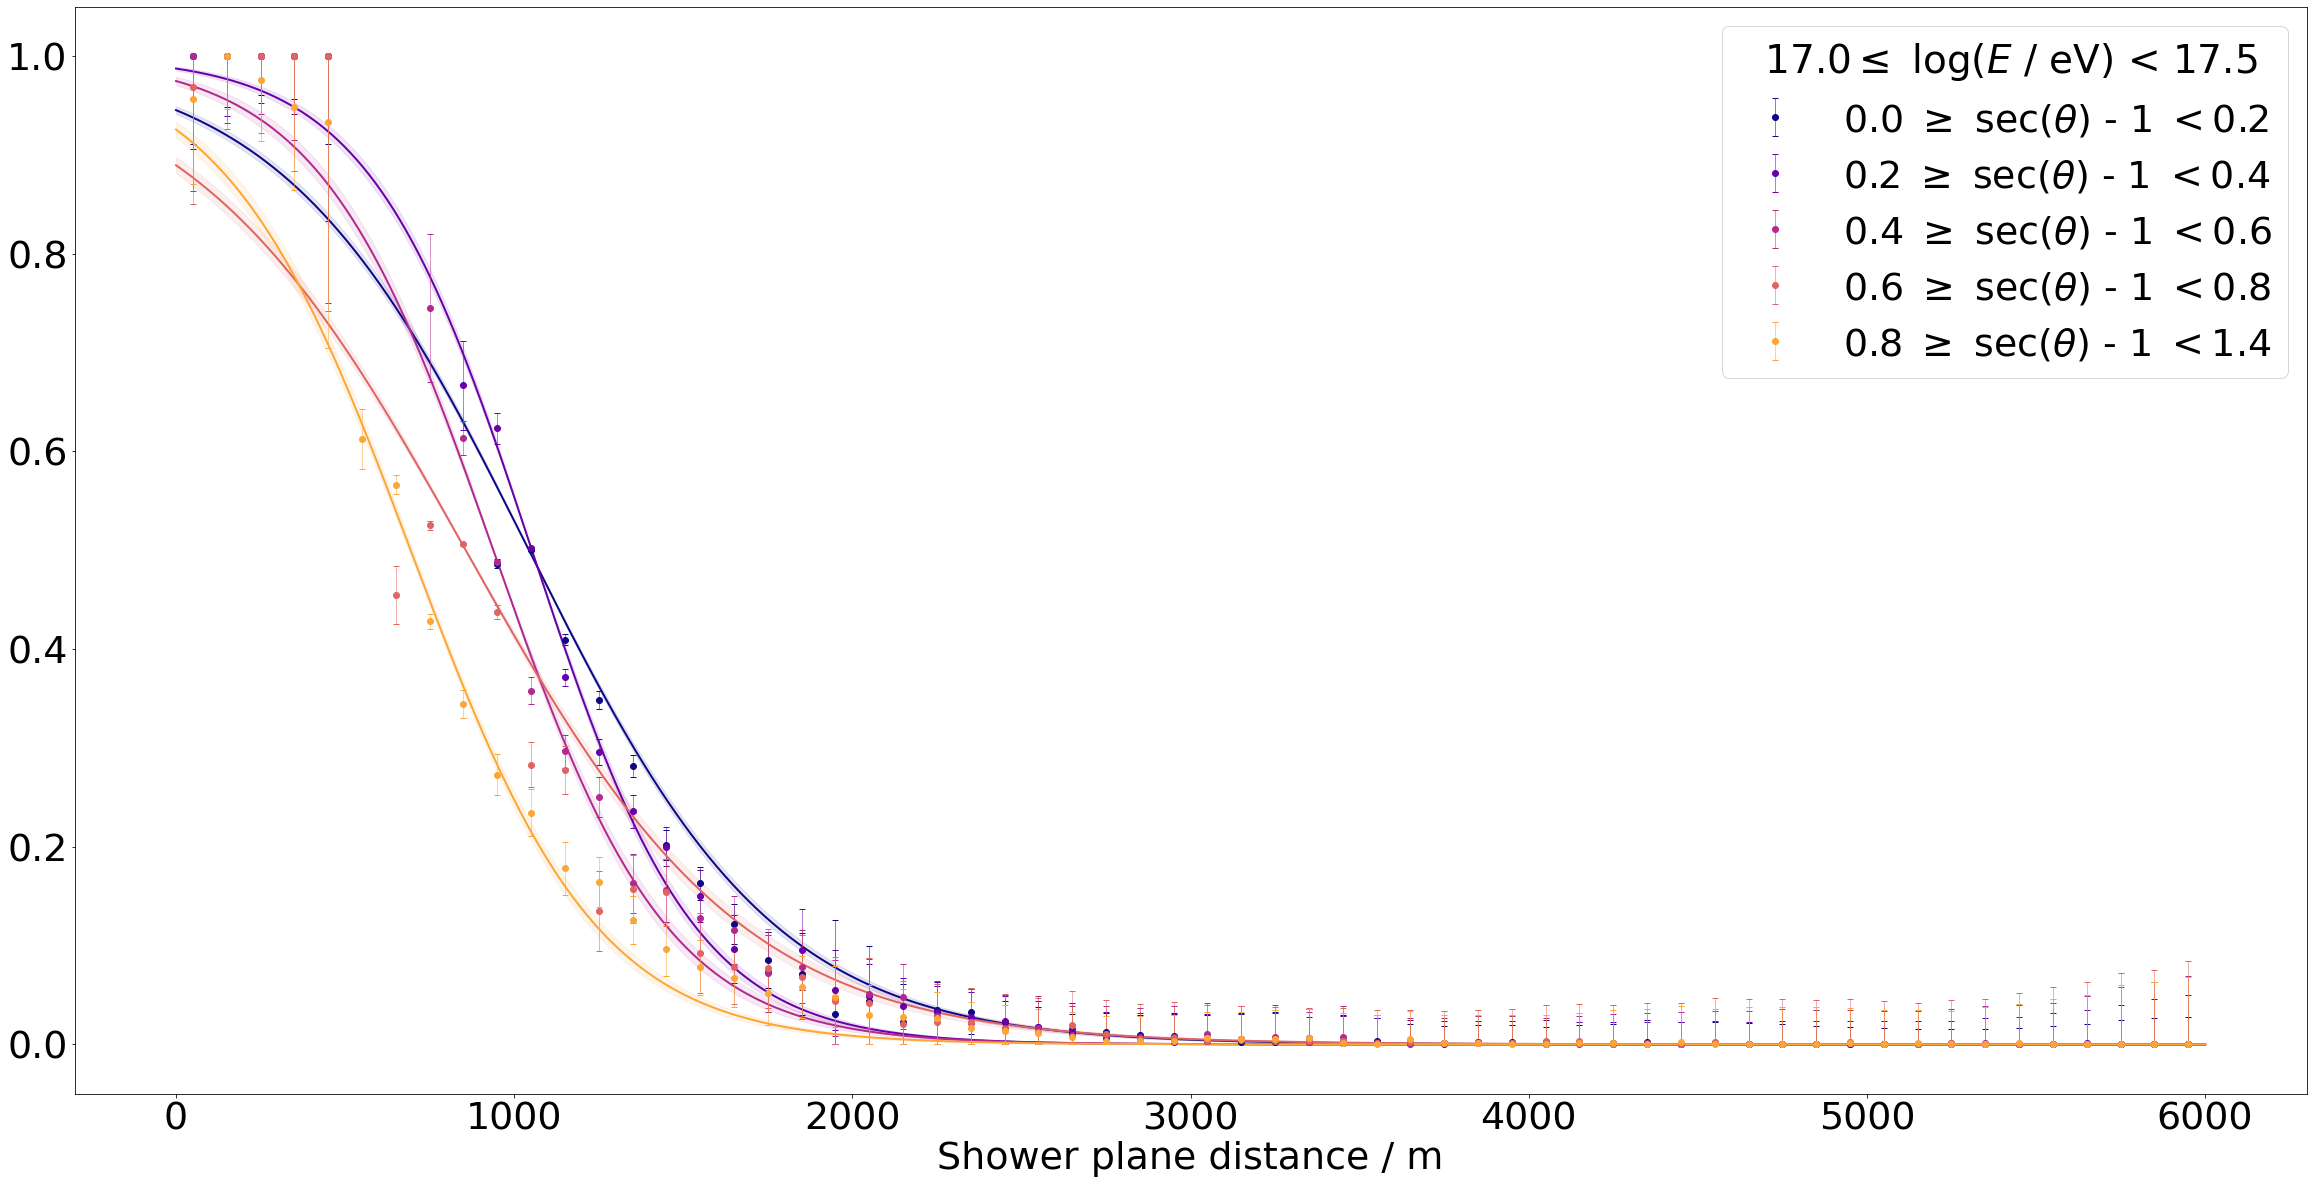

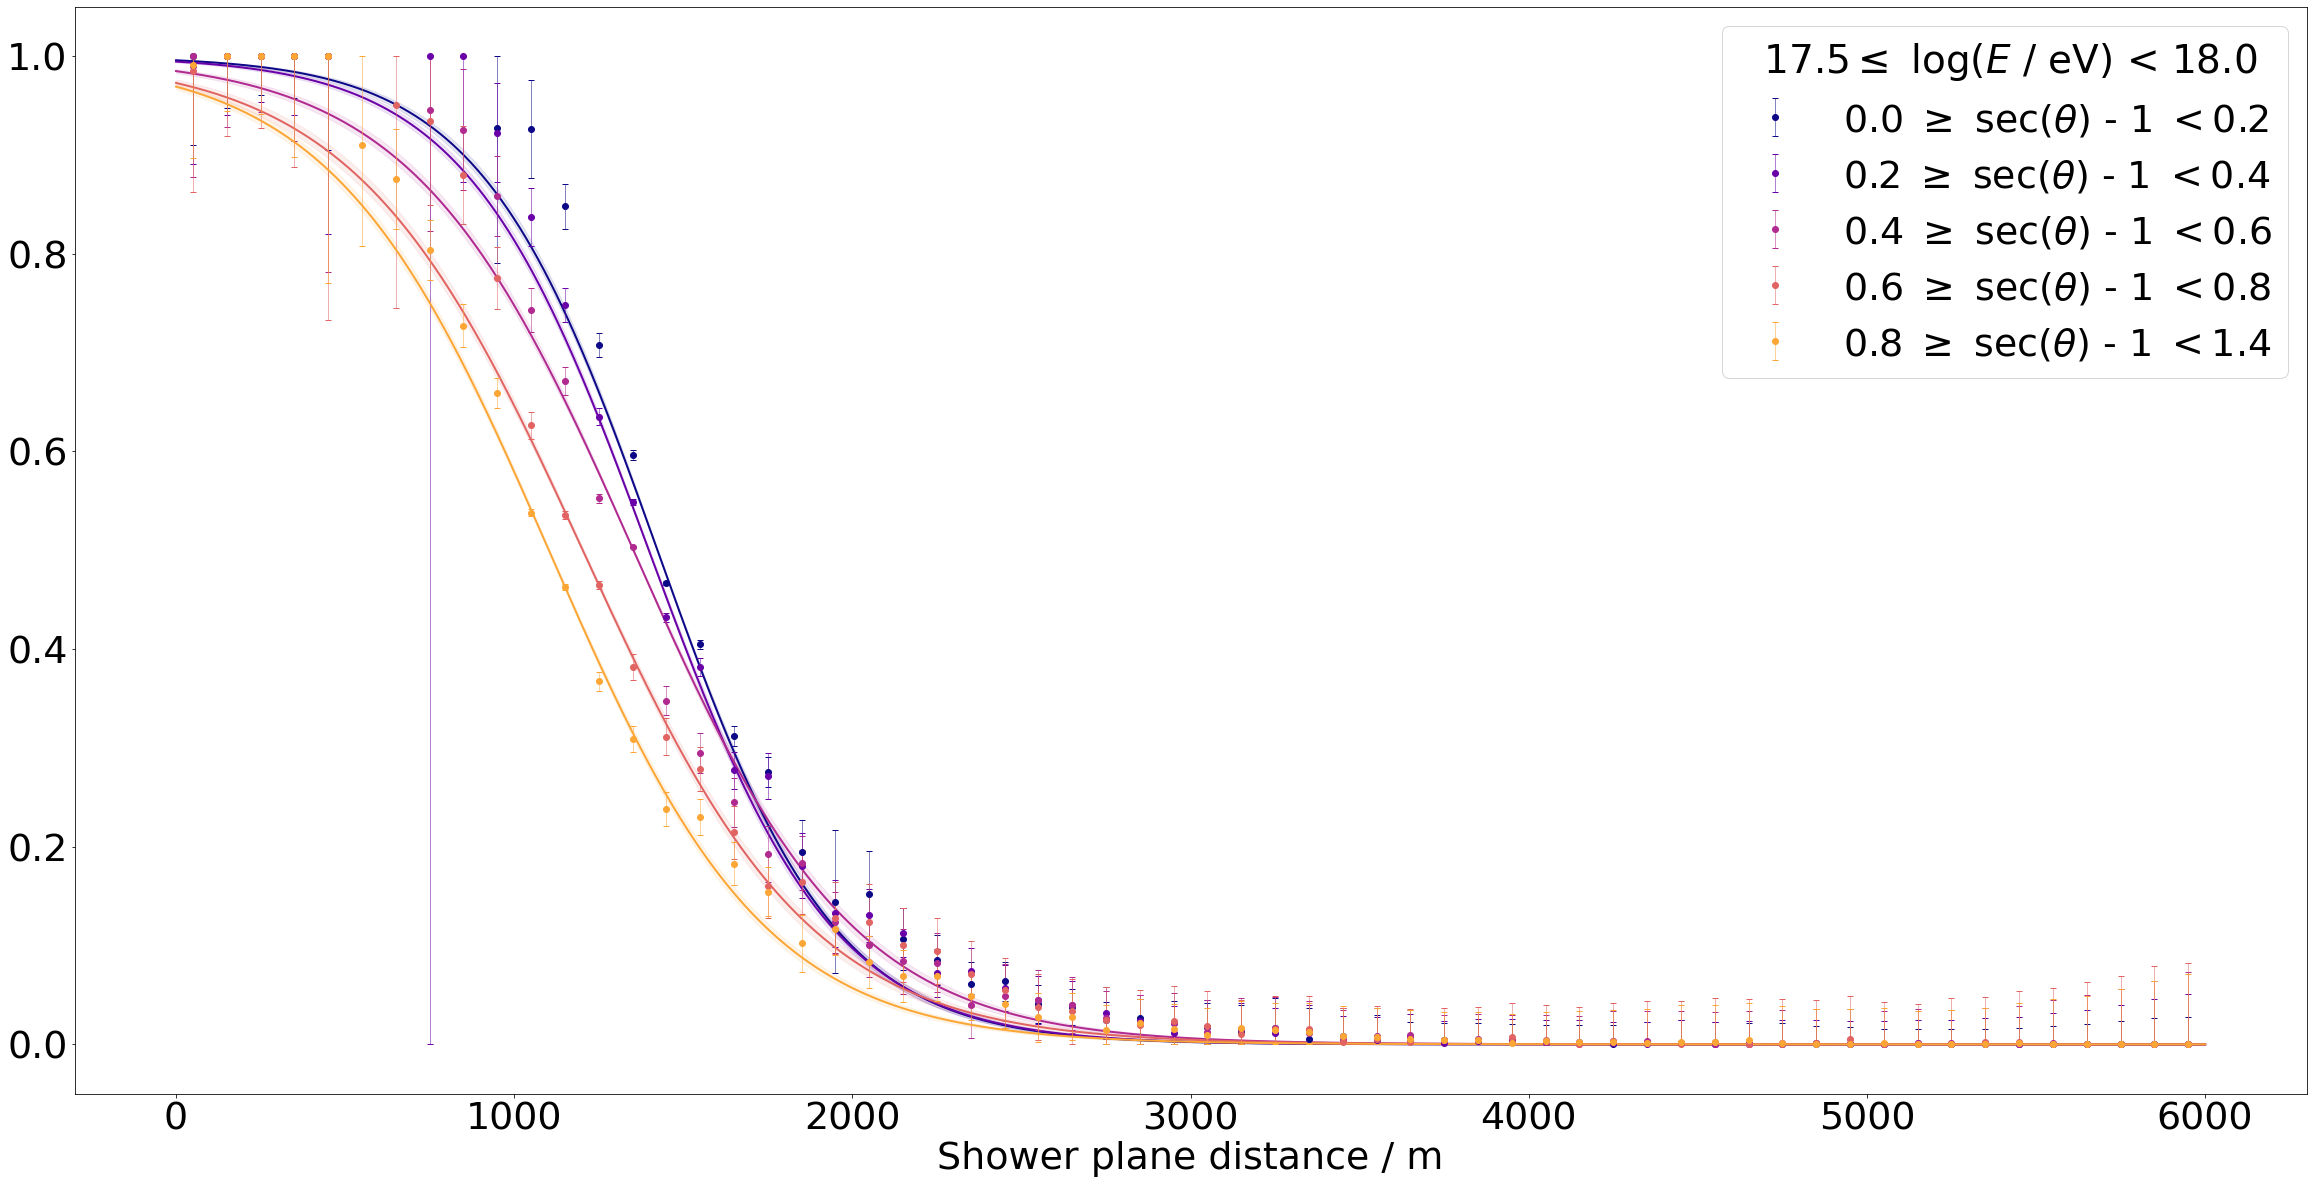

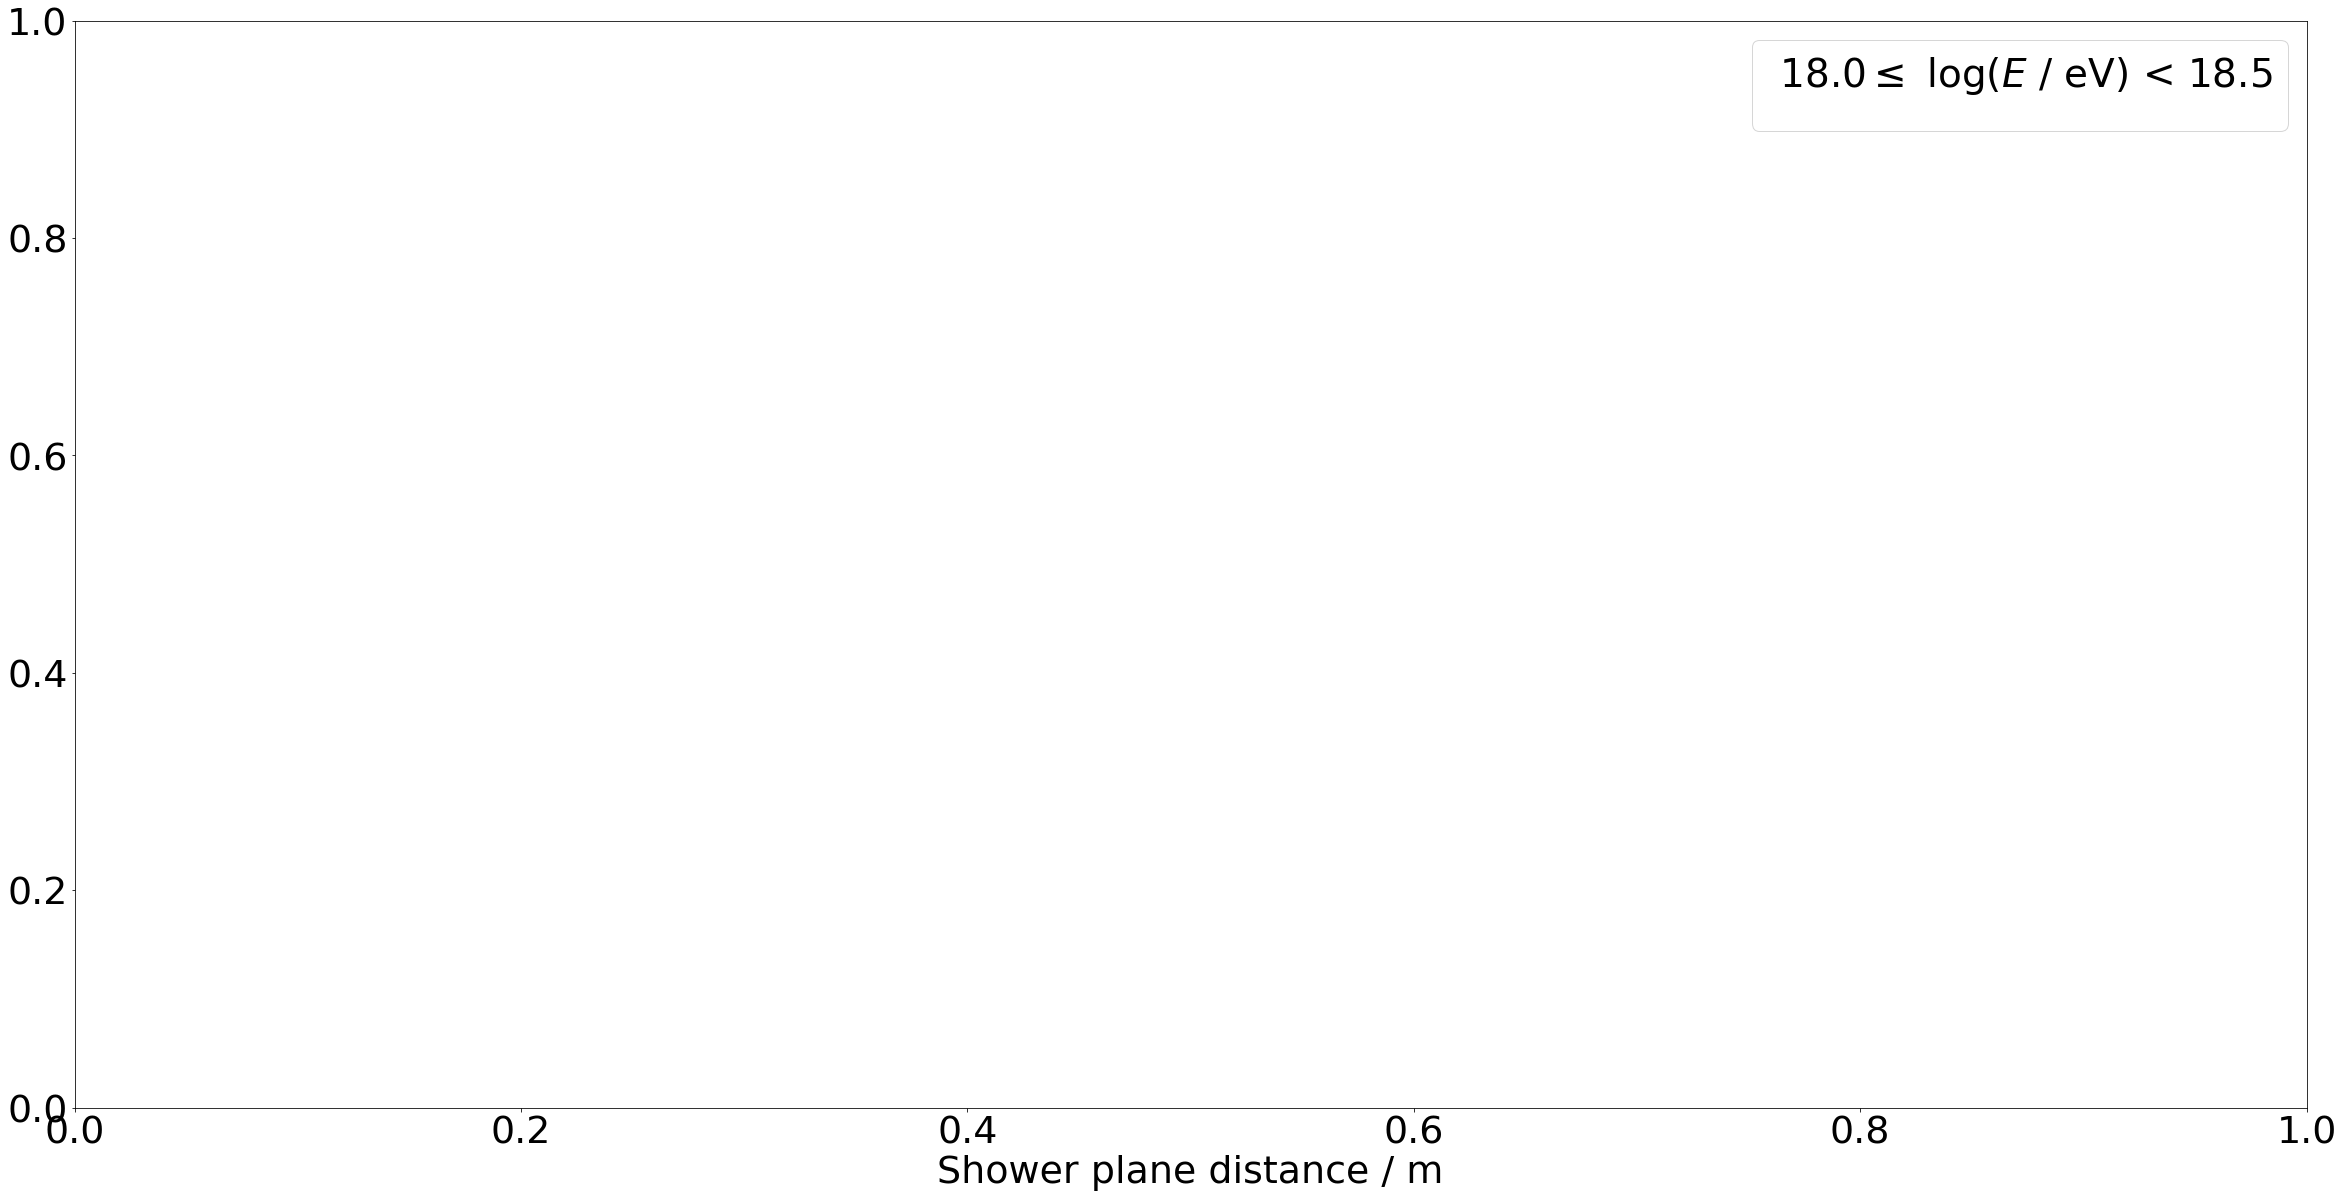

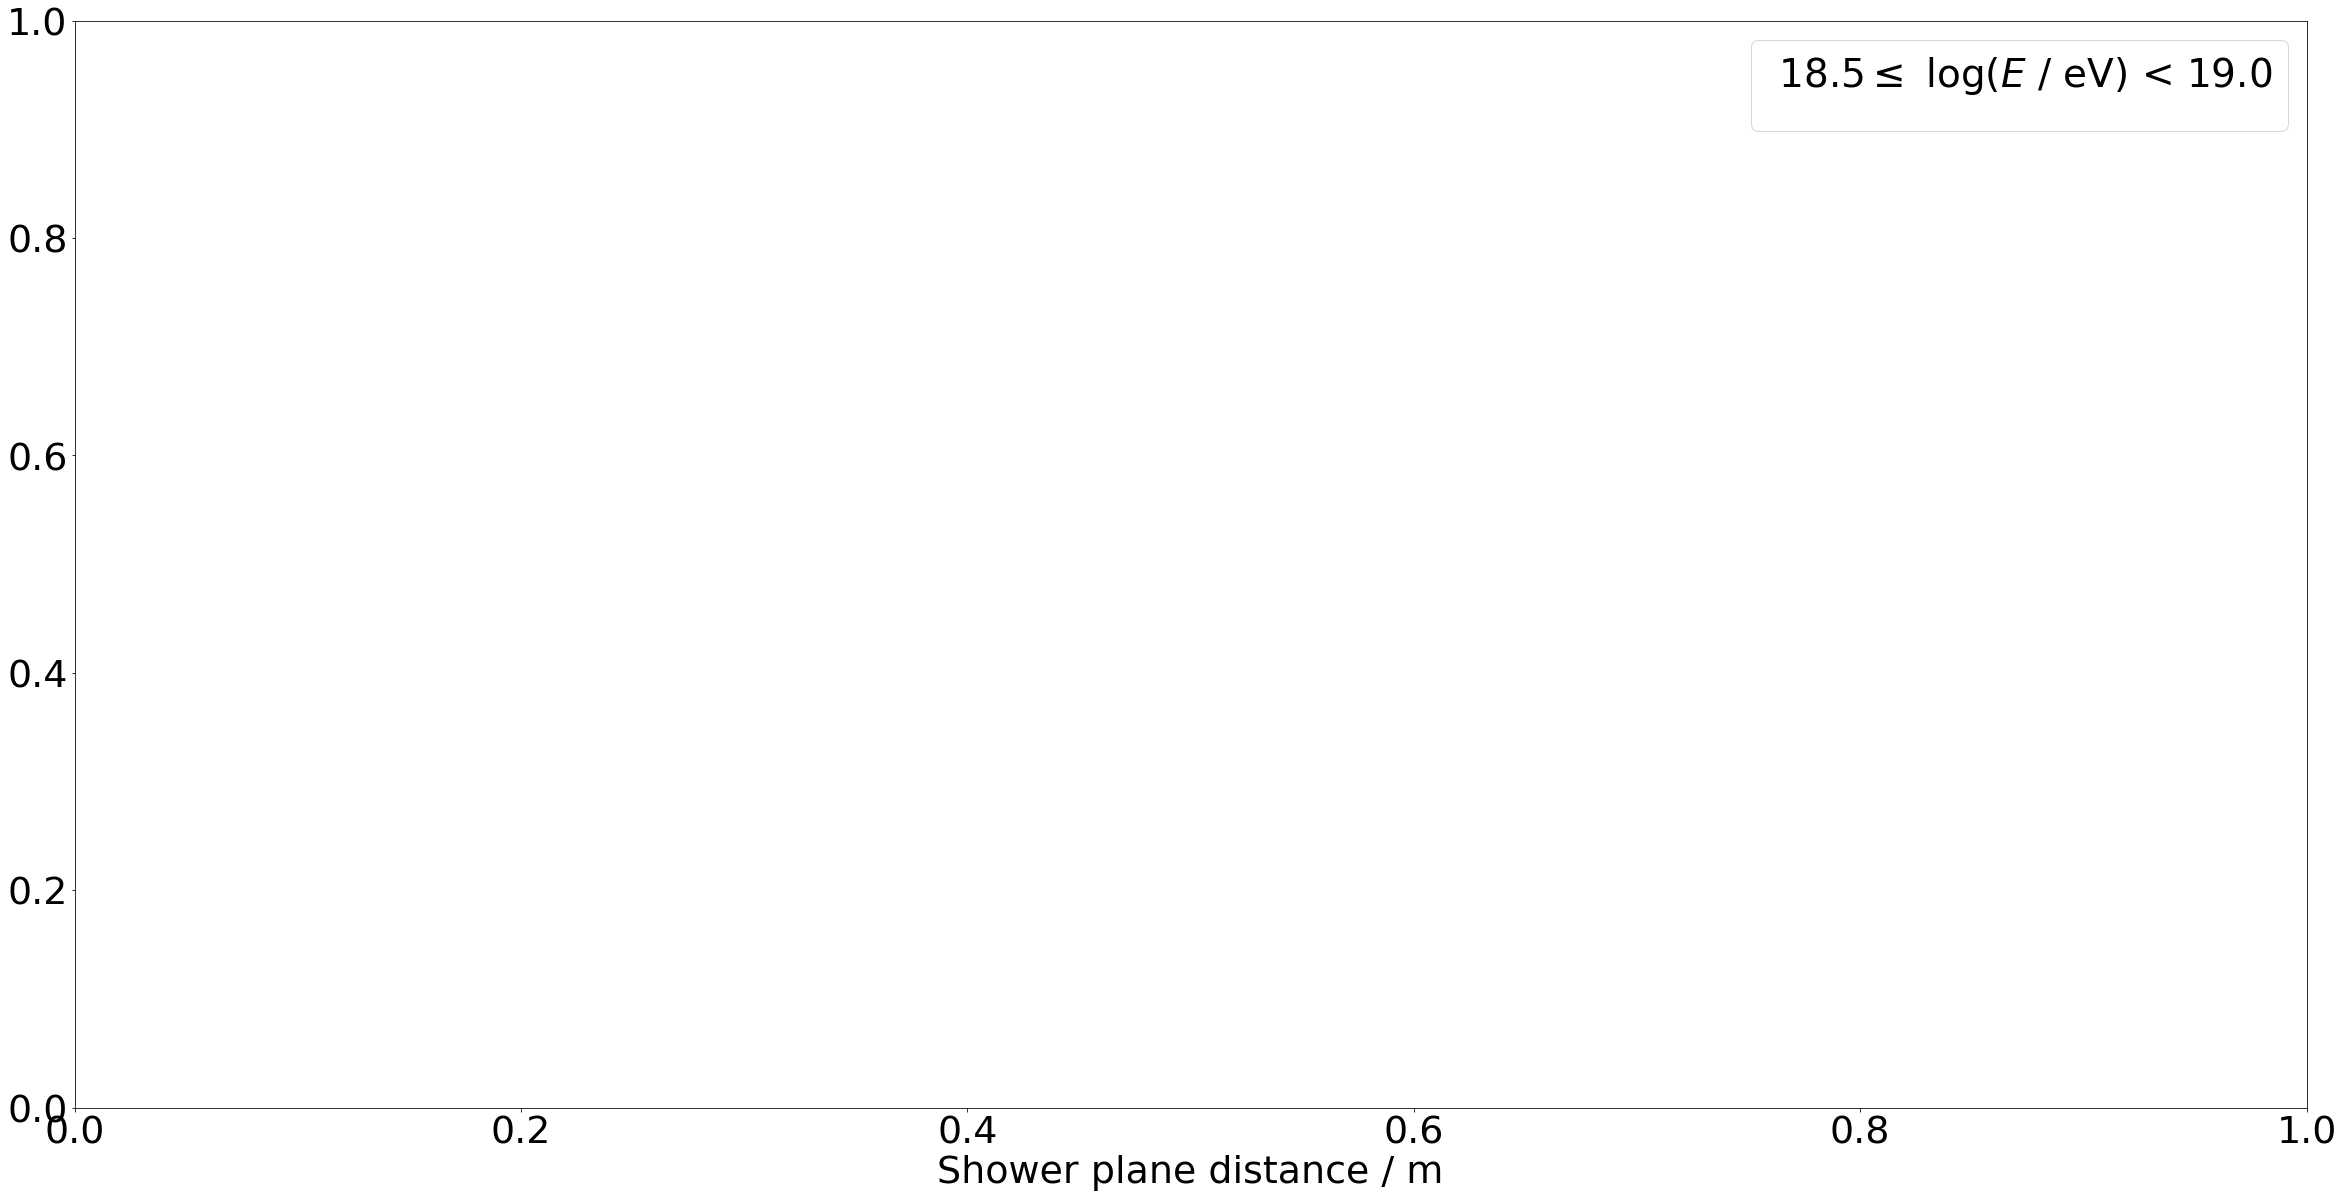

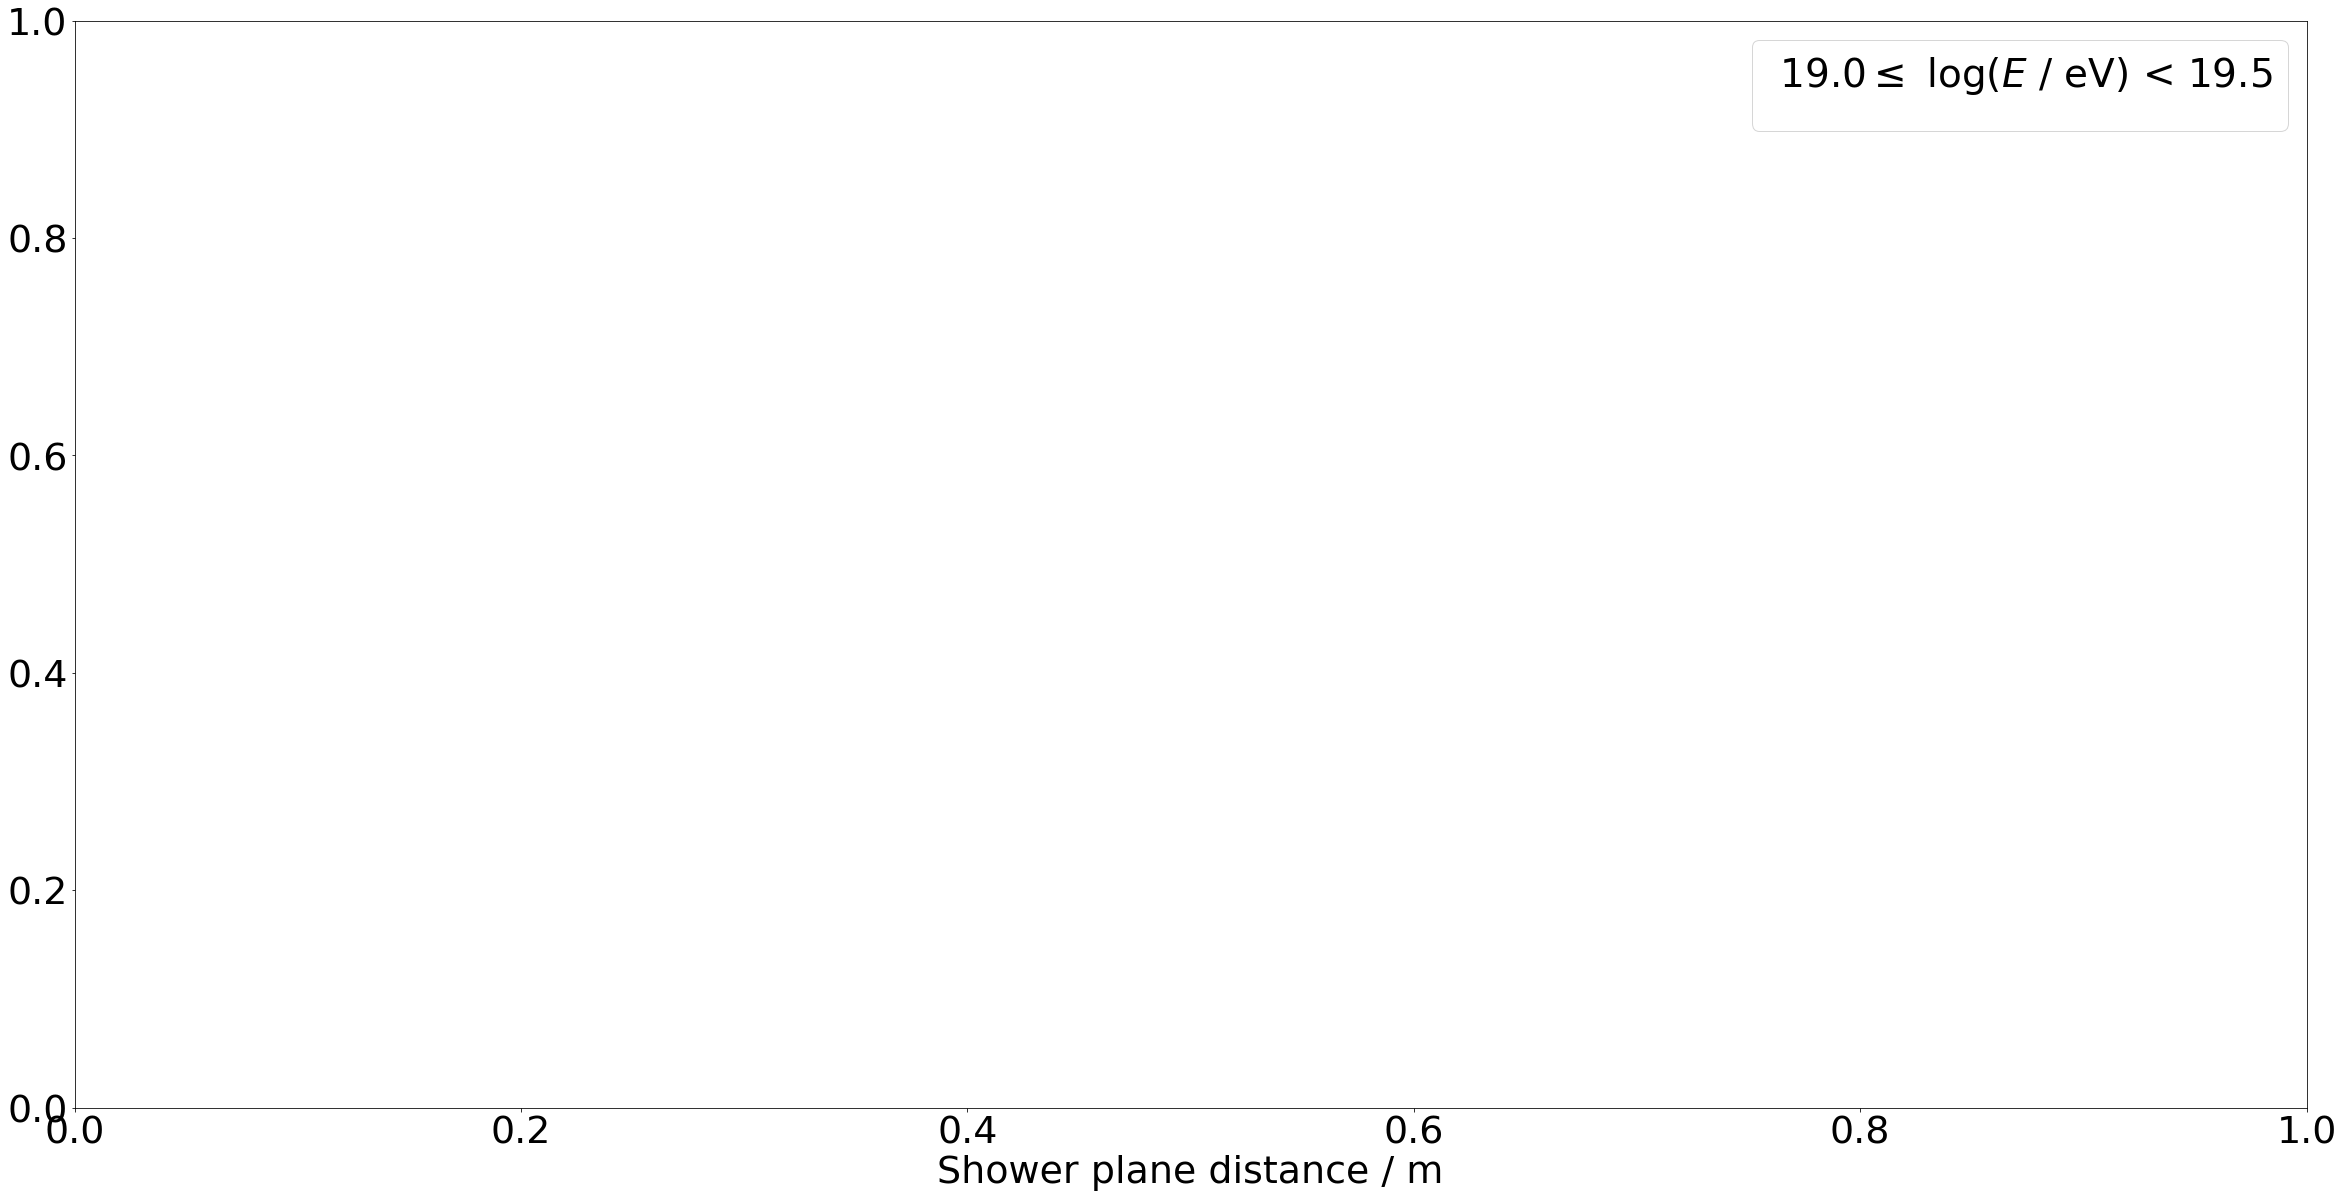

In [2]:
root_path = "/cr/tempdata01/filip/QGSJET-II/LDF/BINNED/"

colormap = cmap.get_cmap("plasma")
plt.rcParams["figure.figsize"] = [40, 20]
# plt.rcParams["figure.figsize"] = [4, 2]
plt.rcParams["font.size"] = 38
warnings.simplefilter("ignore", RuntimeWarning)

t_labels = ["0.0", "0.2", "0.4", "0.6", "0.8", "1.4"]
e_bins = np.array([16, 16.5, 17, 17.5, 18, 18.5, 19])
t_bins = np.array([0, 33, 44, 51, 56])

axes = []

for _ in range(7):
    fig= plt.figure()
    axes.append(plt.gca())

for file in os.listdir(root_path):

    if not file.endswith(".csv"): continue
    spd, hits, misses = np.loadtxt(root_path + file, unpack = True)
    spd, hits, misses = spd[:-5], hits[:-5], misses[:-5]
    efficiency_err = np.clip(1/(hits + misses)**2 * np.sqrt( hits**3 + misses**3 - 2 * np.sqrt((hits * misses)**3) ), 1e-3, 1)
    efficiency = hits / (hits + misses)
    upper = np.clip(efficiency + efficiency_err, 0, 1)
    lower = np.clip(efficiency - efficiency_err, 0, 1)

    c = colormap(np.argmin(abs(float(file[:-4].split("_")[3]) - t_bins)) / len(t_bins))
    ax = axes[np.argmin(abs(float(file[:-4].split("_")[0]) - e_bins))]

    t_label = t_labels[np.argmin(abs(float(file[:-4].split("_")[3]) - t_bins))] + r" $\geq$ sec($\theta$) - 1 $< $" + t_labels[np.argmin(abs(float(file.split("_")[3]) - t_bins)) + 1]
    ax.errorbar(spd - 50, efficiency, yerr = [efficiency - lower, upper - efficiency], capsize = 3, fmt = "o", elinewidth = 0.5, color = c, label = t_label)

    filter = [not np.isnan(item) and not np.isinf(item) for item in efficiency]
    popt, pcov = curve_fit(station_hit_probability, (spd - 50)[filter], efficiency[filter], 
                                                                p0 = [1000, 4e-3],
                                                                bounds = ([0, 0], [6000, 1]),
                                                                sigma = efficiency_err[filter],
                                                                absolute_sigma = True,
                                                                maxfev = 10000)
    
    with open("/cr/tempdata01/filip/QGSJET-II/LDF/FITPARAM/" + file, "w") as stream:
        np.savetxt(stream, np.insert(popt, 0, 1))
    
    X, Y = np.linspace(0, 6e3, 1000), station_hit_probability(np.linspace(0, 6e3, 1000), *popt)
    Y_err = station_hit_probability_error(X, pcov, *popt)
    bottom, top = np.clip(Y - Y_err, 0, 1), np.clip(Y + Y_err, 0, 1)
    
    ax.plot(X, Y, color = c, lw = 2)
    ax.fill_between(X, bottom, top, color = c, alpha = 0.1)

e_bins = list(e_bins) + [19.5]

for e, ax in enumerate(axes):
    ax.legend(title = " " + str(e_bins[e]) + r"$ \leq$ log($E$ / eV) < " + str(e_bins[e + 1]), title_fontsize = 39)
    # ax.set_xlim(0, 6000)
    ax.set_xlabel("Shower plane distance / m")

warnings.simplefilter("default", RuntimeWarning)